In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.models import Model, load_model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.metrics import MeanIoU # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "ds"
IMG_SIZE = (256, 256)
EPOCHS = 50
BATCH_SIZE = 8

In [3]:
def load_and_preprocess_data(data_dir, img_size=(256, 256)):

    classes = ['benign', 'malignant', 'normal']
    class_to_label = {'benign': 0, 'malignant': 1, 'normal': 2}
    
    images = []
    masks = []
    labels = []
    
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            continue
            
        image_files = [f for f in os.listdir(class_dir) 
                      if f.endswith('.png') and not f.endswith('_mask.png')]
        
        for img_file in sorted(image_files):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
                
            mask_path = os.path.join(class_dir, img_file.replace('.png', '_mask.png'))
            if not os.path.exists(mask_path):
                continue
                
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)
            
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)
            
            images.append(img)
            masks.append(mask)
            labels.append(class_to_label[class_name])
    
    images = np.array(images)
    masks = np.array(masks)
    labels = np.array(labels)
    
    return images, masks, labels

In [4]:
images, masks, labels = load_and_preprocess_data(DATA_DIR, IMG_SIZE)

In [5]:
def train_val_test_split(images, masks, labels, test_size=0.2, val_size=0.1):

    X_trainval, X_test, y_trainval_mask, y_test_mask, y_trainval_cls, y_test_cls = train_test_split(images, masks, labels, test_size=test_size, random_state=42)
    
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train_mask, y_val_mask, y_train_cls, y_val_cls = train_test_split(
        X_trainval, y_trainval_mask, y_trainval_cls, test_size=val_size_adjusted, random_state=42)
    
    return (X_train, y_train_mask, y_train_cls), (X_val, y_val_mask, y_val_cls), (X_test, y_test_mask, y_test_cls)

In [6]:
(X_train, y_train_mask, y_train_cls), (X_val, y_val_mask, y_val_cls), (X_test, y_test_mask, y_test_cls) = train_val_test_split(images, masks, labels)

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(alpha=0.7, beta=0.3):
    def loss(y_true, y_pred):

        seg_true, cls_true = y_true[0], y_true[1]
        seg_pred, cls_pred = y_pred[0], y_pred[1]
        
        seg_loss = dice_loss(seg_true, seg_pred) + tf.keras.losses.binary_crossentropy(seg_true, seg_pred)
        
        cls_loss = tf.keras.losses.sparse_categorical_crossentropy(cls_true, cls_pred)
        
        return alpha * seg_loss + beta * cls_loss
    return loss

In [8]:
def multi_task_unet_model(n_classes=3, input_shape=(256, 256, 1)):
    inputs = Input(input_shape)
    s = inputs

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    cls = GlobalAveragePooling2D()(c5)
    cls = Dense(128, activation='relu')(cls)
    cls = Dropout(0.3)(cls)
    
    classification_output = Dense(n_classes, activation='softmax', name='cls_output')(cls)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    segmentation_output = Conv2D(1, (1, 1), activation='sigmoid', name='seg_output')(c9)

    model = Model(inputs=inputs, outputs=[classification_output, segmentation_output], name='MultiTask_UNet')
    return model

In [9]:
def train_model(X_train, y_train_mask, y_train_cls, X_val, y_val_mask, y_val_cls, epochs=50, batch_size=8):
    model = multi_task_unet_model()
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss={'seg_output': dice_loss, 'cls_output': 'sparse_categorical_crossentropy'},
                  metrics={'seg_output': [dice_coef, MeanIoU(num_classes=2)],
                           'cls_output': 'accuracy'},
                  loss_weights={'seg_output': 0.7, 'cls_output': 0.3})

    callbacks = [
        EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
        ModelCheckpoint('best_model.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
    ]

    if len(y_train_cls.shape) > 1 and y_train_cls.shape[1] > 1:
        y_train_cls = np.argmax(y_train_cls, axis=1)
        y_val_cls = np.argmax(y_val_cls, axis=1)
    
    history = model.fit(
        X_train,
        {'seg_output': y_train_mask, 'cls_output': y_train_cls},
        validation_data=(X_val, {'seg_output': y_val_mask, 'cls_output': y_val_cls}),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    
    return model, history

In [58]:
model, history = train_model(X_train, y_train_mask, y_train_cls, X_val, y_val_mask, y_val_cls, EPOCHS, BATCH_SIZE)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - cls_output_accuracy: 0.4244 - cls_output_loss: 0.3191 - loss: 0.9211 - seg_output_dice_coef: 0.1400 - seg_output_loss: 0.6020 - seg_output_mean_io_u_7: 0.4581
Epoch 1: val_loss improved from inf to 0.89528, saving model to best_model.weights.h5
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - cls_output_accuracy: 0.4257 - cls_output_loss: 0.3189 - loss: 0.9210 - seg_output_dice_coef: 0.1399 - seg_output_loss: 0.6021 - seg_output_mean_io_u_7: 0.4581 - val_cls_output_accuracy: 0.5897 - val_cls_output_loss: 0.2959 - val_loss: 0.8953 - val_seg_output_dice_coef: 0.1459 - val_seg_output_loss: 0.5979 - val_seg_output_mean_io_u_7: 0.4622 - learning_rate: 1.0000e-04
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cls_output_accuracy: 0.5472 - cls_output_loss: 0.3009 - loss: 0.8914 - seg_output_dice_coef: 0.1564 - seg_output_loss: 0.5905 - seg_output_mean_io_u_7: 0.4593
Epoch 2: val_loss improved from 0.89528 to 0.89139, saving model to best_model

In [11]:
# model.save('multitask_unet_model.h5')

In [12]:
model = load_model('multitask_unet_model.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

In [13]:
def evaluate_model(model, X_test, y_test_mask, y_test_cls):

    pred_cls, pred_seg = model.predict(X_test)

    pred_seg_binary = (pred_seg > 0.5).astype(np.uint8)

    pred_cls_labels = np.argmax(pred_cls, axis=1)

    cls_acc = accuracy_score(y_test_cls, pred_cls_labels)
    cls_precision = precision_score(y_test_cls, pred_cls_labels, average='weighted', zero_division=0)
    cls_recall = recall_score(y_test_cls, pred_cls_labels, average='weighted', zero_division=0)
    cls_f1 = f1_score(y_test_cls, pred_cls_labels, average='weighted', zero_division=0)

    dice = dice_coef(tf.convert_to_tensor(y_test_mask, dtype=tf.float32), tf.convert_to_tensor(pred_seg_binary, dtype=tf.float32)).numpy()
    miou_metric = MeanIoU(num_classes=2)
    miou_metric.update_state(y_test_mask, pred_seg_binary)
    miou = miou_metric.result().numpy()
    pixel_accuracy = np.mean(pred_seg_binary == y_test_mask)

    print("Segmentation Metrics")
    print(f"Dice Coefficient      : {dice:.4f}")
    print(f"Mean IoU (mIoU)       : {miou:.4f}")
    print(f"Pixel Accuracy        : {pixel_accuracy:.4f}")

    print("Classification Metrics")
    print(f"Accuracy              : {cls_acc:.4f}")
    print(f"Precision             : {cls_precision:.4f}")
    print(f"Recall                : {cls_recall:.4f}")
    print(f"F1 Score              : {cls_f1:.4f}")

In [14]:
evaluate_model(model, X_test, y_test_mask, y_test_cls)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 843ms/step
Segmentation Metrics
Dice Coefficient      : 0.6369
Mean IoU (mIoU)       : 0.7074
Pixel Accuracy        : 0.9498
Classification Metrics
Accuracy              : 0.6667
Precision             : 0.6808
Recall                : 0.6667
F1 Score              : 0.6608


In [15]:
evaluate_model(model, X_val, y_val_mask, y_val_cls)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step
Segmentation Metrics
Dice Coefficient      : 0.6416
Mean IoU (mIoU)       : 0.7109
Pixel Accuracy        : 0.9517
Classification Metrics
Accuracy              : 0.7308
Precision             : 0.7396
Recall                : 0.7308
F1 Score              : 0.7238


In [16]:
def plot_sample_prediction(model, X_test, y_test_mask, y_test_cls, num_samples=3):

    pred_classes, pred_masks = model.predict(X_test)
    pred_classes = np.argmax(pred_classes, axis=1)
    pred_masks_binary = (pred_masks > 0.5).astype(np.float32)
    
    dice_scores = []
    for i in range(len(X_test)):
        dice = dice_coef(
            tf.convert_to_tensor(y_test_mask[i:i+1], dtype=tf.float32), 
            tf.convert_to_tensor(pred_masks[i:i+1], dtype=tf.float32)
        ).numpy()
        dice_scores.append(dice)
    
    dice_scores = np.array(dice_scores)
    
    best_indices = np.argsort(dice_scores)[-num_samples:][::-1]
    worst_indices = np.argsort(dice_scores)[:num_samples]
    
    print("Best Predictions (High Dice Score):")
    plt.figure(figsize=(15, 5 * num_samples))
    for idx, i in enumerate(best_indices):
        plt.subplot(num_samples, 3, idx * 3 + 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title(f"Original Image\nTrue Class: {y_test_cls[i]}")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, idx * 3 + 2)
        plt.imshow(y_test_mask[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, idx * 3 + 3)
        plt.imshow(pred_masks_binary[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask\nPred Class: {pred_classes[i]}\nDice: {dice_scores[i]:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    print("\nWorst Predictions (Low Dice Score):")
    plt.figure(figsize=(15, 5 * num_samples))
    for idx, i in enumerate(worst_indices):
        plt.subplot(num_samples, 3, idx * 3 + 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title(f"Original Image\nTrue Class: {y_test_cls[i]}")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, idx * 3 + 2)
        plt.imshow(y_test_mask[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, idx * 3 + 3)
        plt.imshow(pred_masks_binary[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask\nPred Class: {pred_classes[i]}\nDice: {dice_scores[i]:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 803ms/step
Best Predictions (High Dice Score):


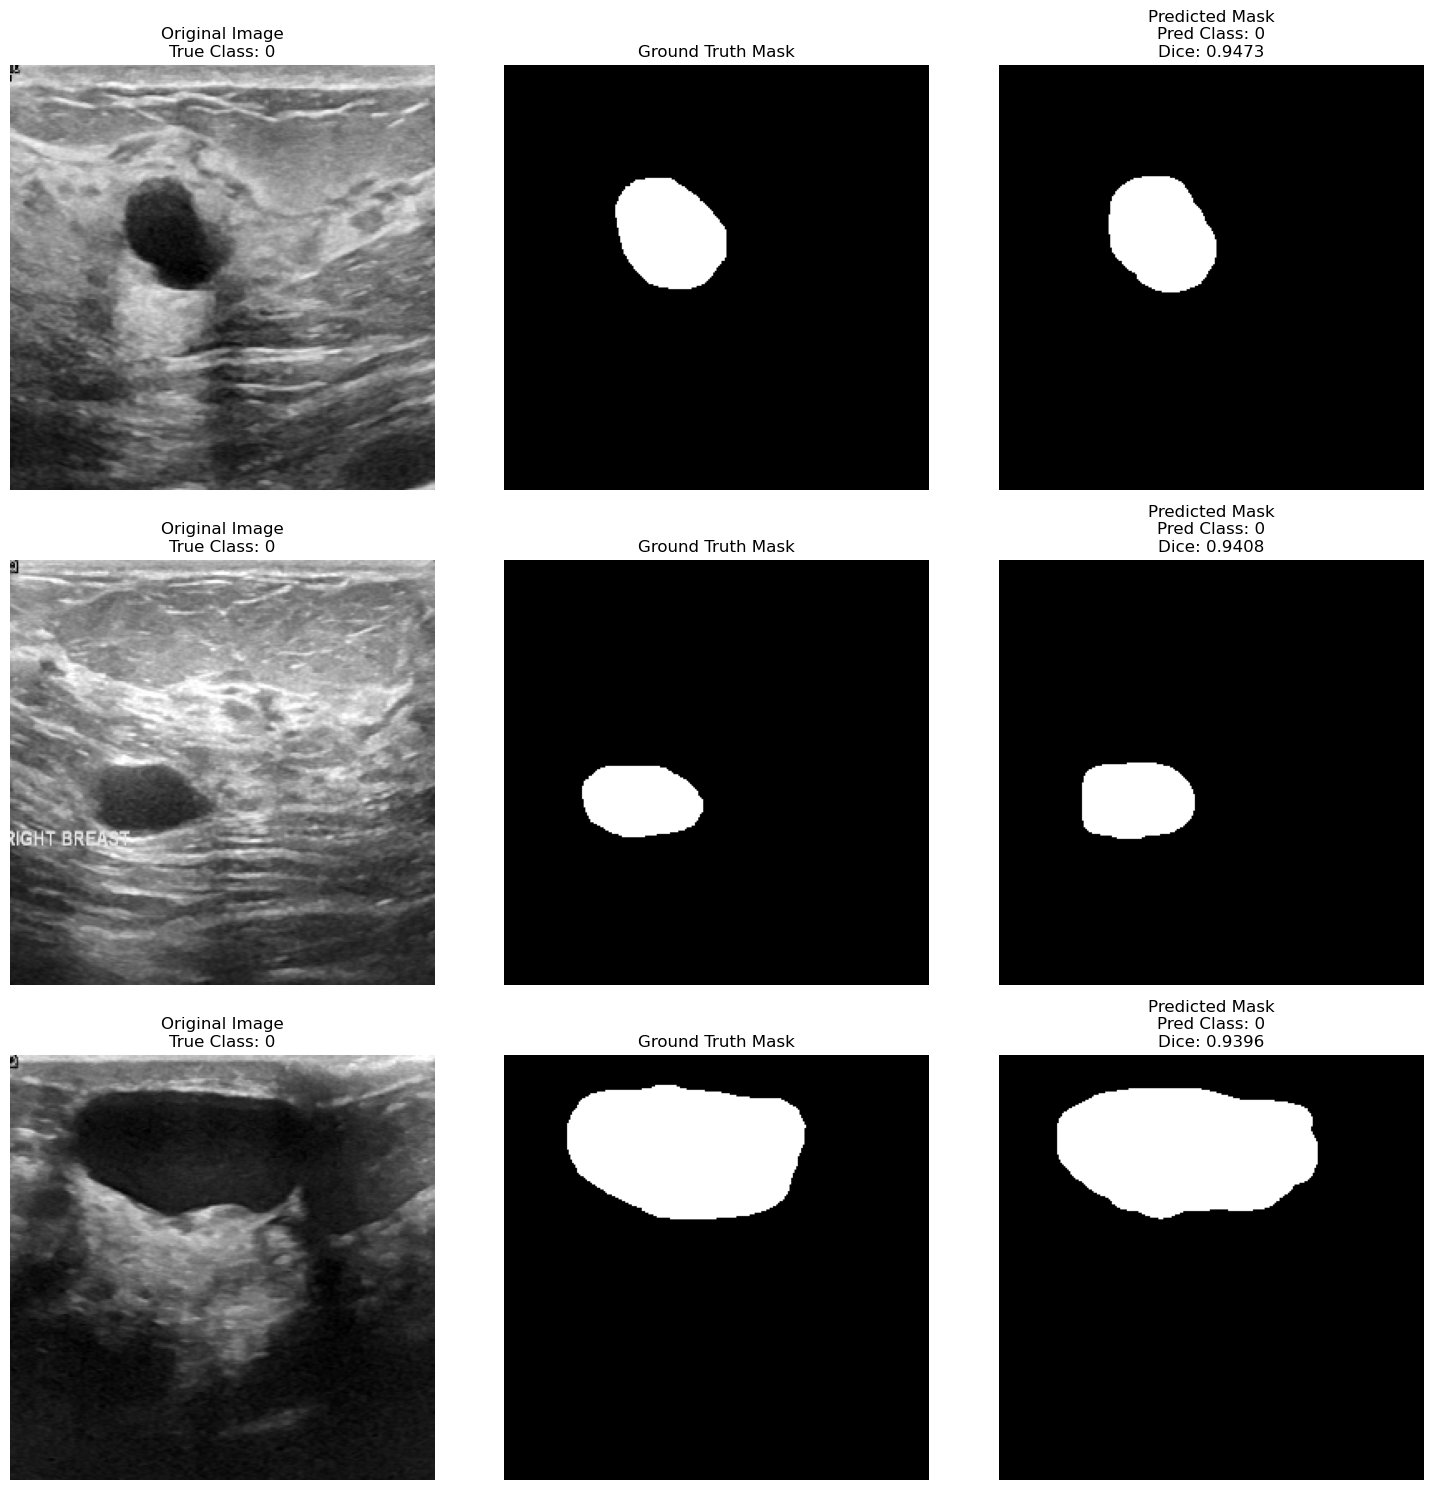


Worst Predictions (Low Dice Score):


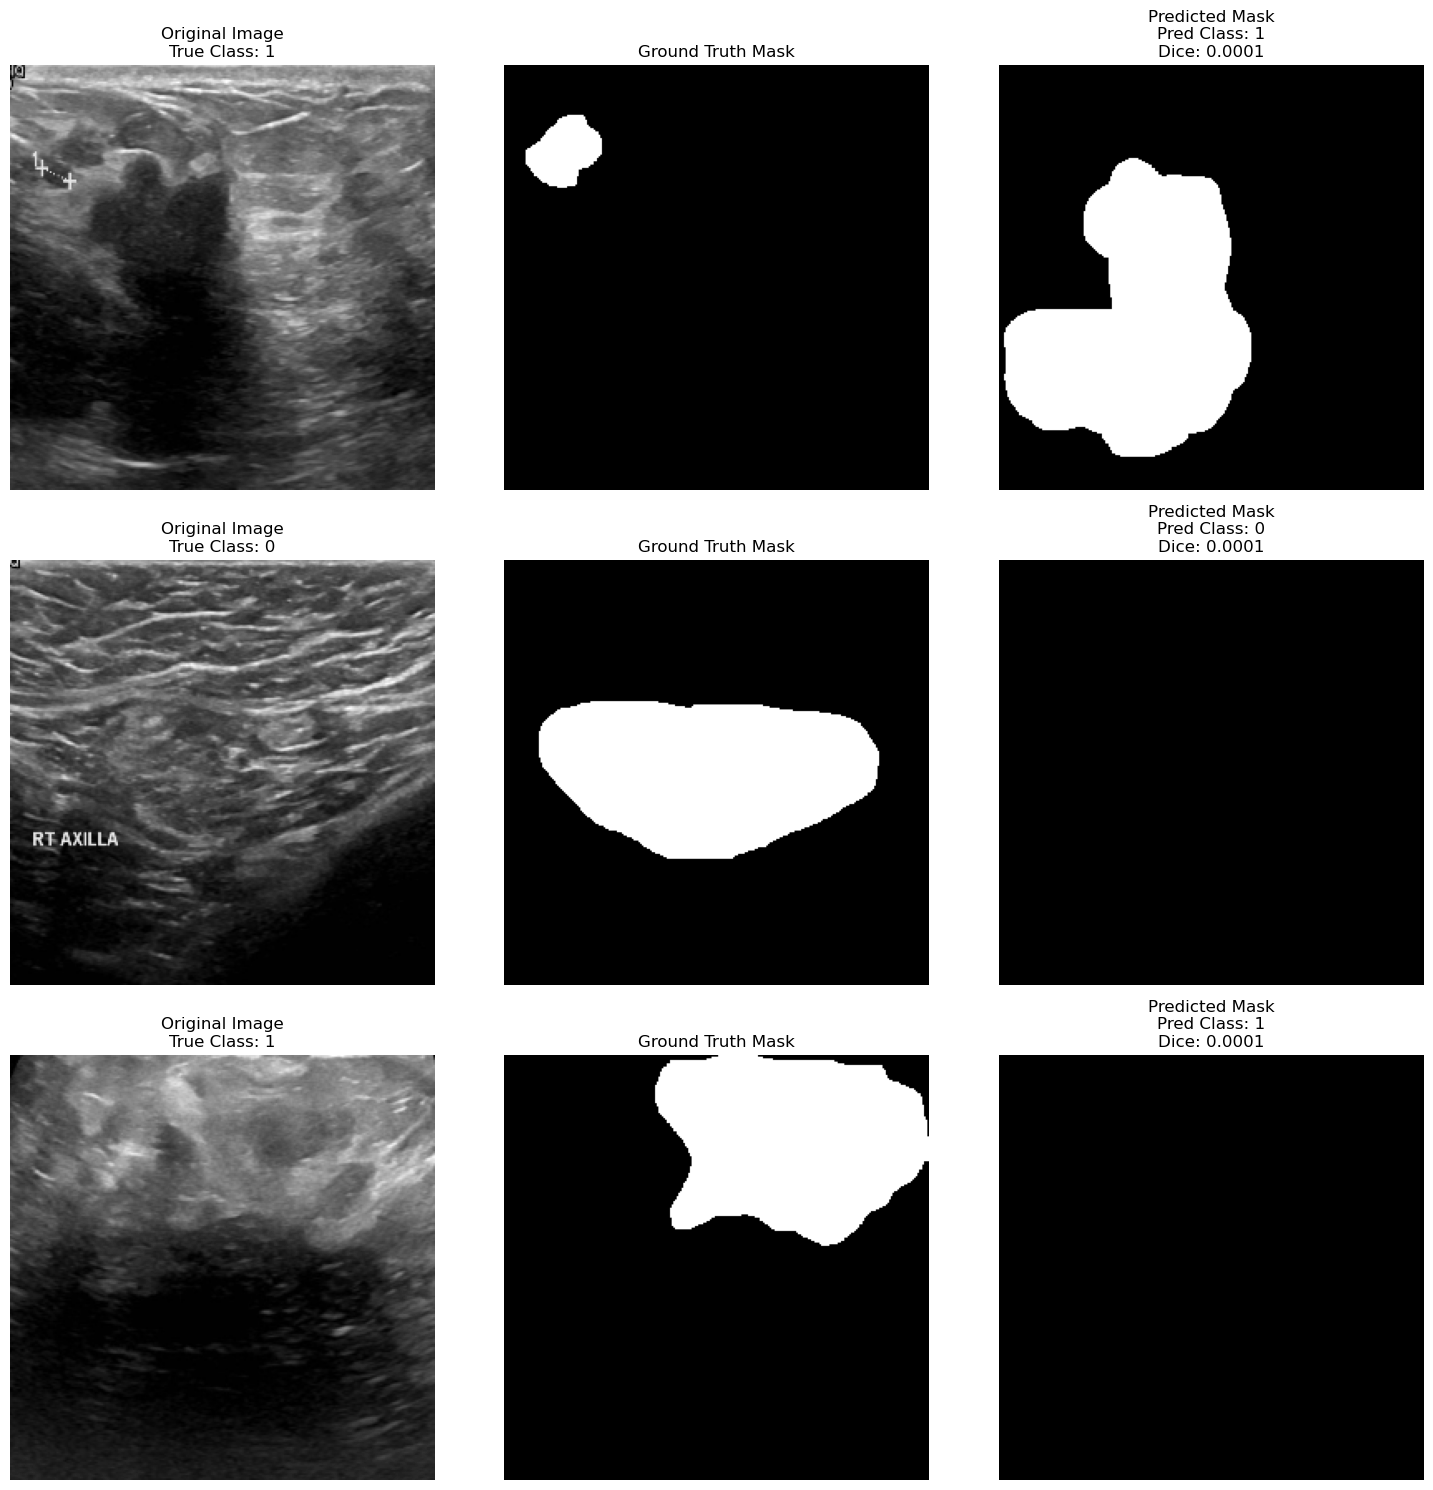

In [17]:
plot_sample_prediction(model, X_test, y_test_mask, y_test_cls)